In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [6]:
# 1. Cargar el dataset
df = pd.read_csv("yellow_tripdata_2016-03.csv", parse_dates=["tpep_pickup_datetime"], index_col="tpep_pickup_datetime")
print(df.head())
print(df.info())

                      VendorID tpep_dropoff_datetime  passenger_count  \
tpep_pickup_datetime                                                    
2016-03-01                   1   2016-03-01 00:07:55                1   
2016-03-01                   1   2016-03-01 00:11:06                1   
2016-03-01                   2   2016-03-01 00:31:06                2   
2016-03-01                   2   2016-03-01 00:00:00                3   
2016-03-01                   2   2016-03-01 00:00:00                5   

                      trip_distance  pickup_longitude  pickup_latitude  \
tpep_pickup_datetime                                                     
2016-03-01                     2.50        -73.976746        40.765152   
2016-03-01                     2.90        -73.983482        40.767925   
2016-03-01                    19.98        -73.782021        40.644810   
2016-03-01                    10.78        -73.863419        40.769814   
2016-03-01                    30.43        -

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


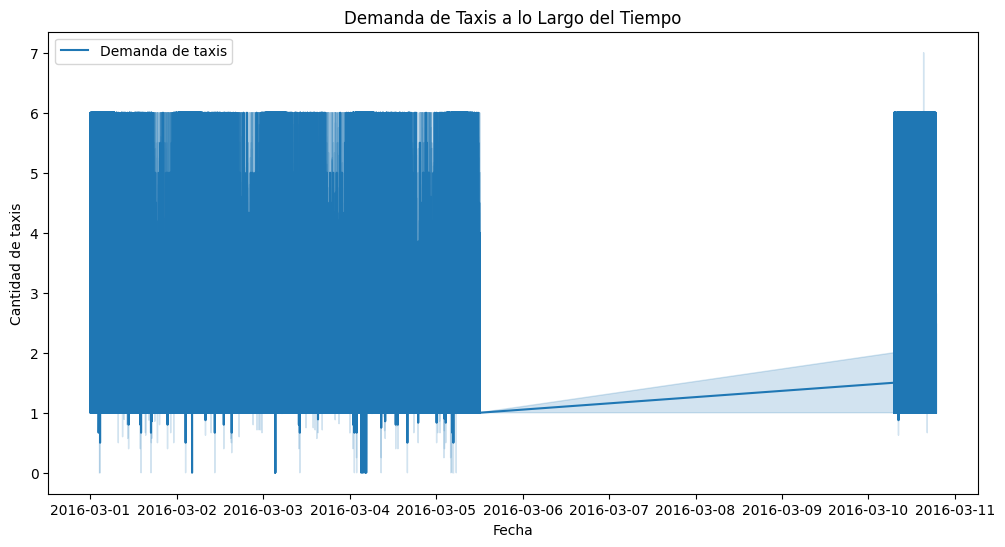

In [5]:
# 2. Visualización inicial
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df["passenger_count"], label="Demanda de taxis")
plt.title("Demanda de Taxis a lo Largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de taxis")
plt.legend()
plt.show()

In [ ]:
# 3. Modelo ARIMA
train_size = int(len(df) * 0.8)
train, test = df["passenger_count"][:train_size], df["passenger_count"][train_size:]
model_arima = ARIMA(train, order=(5,1,0))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=len(test))
print("MAE ARIMA:", mean_absolute_error(test, forecast_arima))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

In [ ]:
# 4. Modelo Prophet
df_prophet = df.reset_index()[["tpep_pickup_datetime", "passenger_count"]]
df_prophet.columns = ["ds", "y"]
model_prophet = Prophet()
model_prophet.fit(df_prophet[:train_size])
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast_prophet = model_prophet.predict(future)
y_pred_prophet = forecast_prophet["yhat"].iloc[-len(test):]
print("MAE Prophet:", mean_absolute_error(test, y_pred_prophet))

In [ ]:
# 5. Modelo LSTM
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[["passenger_count"]])
X, y = [], []
for i in range(10, len(data_scaled)):
    X.append(data_scaled[i-10:i])
    y.append(data_scaled[i])
X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(10, 1)),
    LSTM(50),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
print("MAE LSTM:", mean_absolute_error(test, y_pred_lstm))

In [ ]:
# 6. Visualización de resultados
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Real")
plt.plot(test.index, forecast_arima, label="ARIMA")
plt.plot(test.index, y_pred_prophet, label="Prophet")
plt.plot(test.index, y_pred_lstm, label="LSTM")
plt.legend()
plt.title("Comparación de Modelos")
plt.show()